## 🔗 Joint PDF (Truth vs Prediction)

평균 밀도:

$$
\rho_{0} = \langle \rho \rangle
$$

정규화된 밀도 변수:

$$
x_{\text{true}} = \frac{\rho_{\text{true}}}{\rho_{0}}
$$

$$
x_{\text{pred}} = \frac{\rho_{\text{pred}}}{\rho_{0}}
$$

Joint PDF 정의:

$$
P(x_{\text{true}}, x_{\text{pred}}) \approx
\frac{N(x_{\text{true}}, x_{\text{pred}})}
{N_{\text{tot}} \, \Delta x_{\text{true}} \, \Delta x_{\text{pred}}}
$$

**해석 가이드:**

- 대각선 근처일수록 모델 예측이 정확함

  $$
  x_{\text{pred}} = x_{\text{true}}
  $$

- 대각선 아래 영역 → 과소 예측 (under-prediction)
- 대각선 위 영역 → 과대 예측 (over-prediction)

---

## 📊 Density PDF (Log-Binned)

평균 밀도:

$$
\rho_{0} = \langle \rho \rangle
$$

정규화된 밀도 변수:

$$
x = \frac{\rho}{\rho_{0}}
$$

로그 비닝된 PDF:

$$
\frac{dP}{d\log_{10}x}
=
\frac{1}{N_{\text{tot}}}
\frac{N_j}{\Delta \log_{10} x}
$$

bin 중심 (기하 평균):

$$
x_j = \sqrt{b_j \, b_{j+1}}
$$

---


In [21]:
# === Structural panels from cached CSV/NPZ (Jupyter-safe) ===
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patheffects as pe

# ---- Loaders that match your writer (make_structural_panels.py) ----
def _read_pdf_bin_centers(path):
    """bins_pdf.csv → centers via geometric mean of [bin_low, bin_high]."""
    df = pd.read_csv(os.path.join(path, "bins_pdf.csv"))
    if {"bin_low","bin_high"}.issubset(df.columns):
        low, high = df["bin_low"].to_numpy(), df["bin_high"].to_numpy()
        centers = np.sqrt(low * high)
    else:
        centers = df.iloc[:,0].to_numpy()  # fallback
    return centers

def _read_r_bins(path):
    """r_bins.csv → r-centers (first column)."""
    df = pd.read_csv(os.path.join(path, "r_bins.csv"))
    return df.iloc[:,0].to_numpy()

def _read_percentiles_csv(path, stem):
    """Return (p16, p50, p84) for a given file stem without x-column."""
    df = pd.read_csv(os.path.join(path, f"{stem}.csv"))
    return df["p16"].to_numpy(), df["p50"].to_numpy(), df["p84"].to_numpy()

def _load_joint_npz(path, model_key):
    """Load joint bins, histogram, and contour levels for a model."""
    npz = np.load(os.path.join(path, "joint2d_histograms.npz"))
    bins = npz["JOINT_BINS"]
    if model_key.lower() == "base":
        H, thr = npz["H_Base"], npz["thr_Base"]
    elif model_key.lower() == "unet":
        H, thr = npz["H_UNet"], npz["thr_UNet"]
    elif model_key.lower() == "vit":
        H, thr = npz["H_ViT"], npz["thr_ViT"]
    else:
        raise ValueError("model_key must be one of: base, unet, vit")
    return bins, H, thr

# ---- Plotter ----
def plot_struct_panel_from_cache(
    path,
    model="base",
    title="TNG300",
    savepath=None,
    trim_bins=1,           # PDF 패널에서 좌우 한 칸씩 트림
    joint_xlim=(1e-3, 1e3) # Joint 패널 x/y 범위 강제
):
    """
    Recreates the 3-panel figure (Joint, Density PDF, 2PCF) from cached files.
    model ∈ {"base","unet","vit"}.
    """
    model_upper = {"base":"Base","unet":"UNet","vit":"ViT"}[model.lower()]
    color = {"base":"#1f77b4", "unet":"#ff7f0e", "vit":"#d62728"}[model.lower()]

    # --- load axes
    pdf_x  = _read_pdf_bin_centers(path)   # length B
    r_axis = _read_r_bins(path)            # length R

    # --- percentiles (truth + model)
    t_pdf16, t_pdf50, t_pdf84 = _read_percentiles_csv(path, "truth_pdf_percentiles")
    m_pdf16, m_pdf50, m_pdf84 = _read_percentiles_csv(path, f"{model.lower()}_pdf_percentiles")

    t_xi16,  t_xi50,  t_xi84  = _read_percentiles_csv(path, "truth_xi_percentiles")
    m_xi16,  m_xi50,  m_xi84  = _read_percentiles_csv(path, f"{model.lower()}_xi_percentiles")

    # --- joint 2D histogram & levels
    joint_bins, H2d, thr = _load_joint_npz(path, model)
    pdf2d = H2d / max(H2d.sum(), 1.0)  # per-cell probability

    # --- figure ---
    fig, axs = plt.subplots(1, 3, figsize=(15.8, 4.6), constrained_layout=False)

    # ===== (a) Joint truth vs pred with line-only contours =====
    xb, yb = joint_bins, joint_bins
    xc = 0.5 * (xb[:-1] + xb[1:])
    yc = 0.5 * (yb[:-1] + yb[1:])

    axs[0].set_xscale("log"); axs[0].set_yscale("log")
    # 요청: x축 1e-3 ~ 1e3로, 대칭성을 위해 y축도 동일 범위
    axs[0].set_xlim(*joint_xlim)
    axs[0].set_ylim(*joint_xlim)

    # Mask zeros and use robust vmin/vmax from positive counts
    Hmask = np.ma.masked_less_equal(H2d, 0.0)
    if np.any(H2d > 0):
        pos = H2d[H2d > 0]
        vmin = np.percentile(pos, 5.0)
        vmax = np.percentile(pos, 99.5)
        if vmin <= 0: vmin = pos.min()
    else:
        vmin, vmax = 1.0, 1.0  # degenerate fallback

    pcm = axs[0].pcolormesh(
        xb, yb, Hmask.T, shading="auto",
        norm=LogNorm(vmin=max(vmin, 1e-16), vmax=max(vmax, vmin*10)),
        cmap="viridis", zorder=1
    )
    axs[0].plot([xb[0], xb[-1]], [yb[0], yb[-1]], ls="--", c="k", lw=1.2, alpha=0.8, zorder=2)

    # ---- Contour levels (1σ/2σ/3σ) ----
    levels = np.array(thr, dtype=float)
    levels = np.sort(np.unique(levels))

    if np.any(pdf2d > 0):
        pmin = float(np.nanmin(pdf2d[pdf2d > 0]))
        pmax = float(np.nanmax(pdf2d))
        levels = levels[(levels > pmin) & (levels < pmax)]

    if levels.size >= 2:
        axs[0].contour(
            xc, yc, pdf2d.T,
            levels=levels,
            colors=["red", "darkorange", "gold"][:levels.size],
            linewidths=[1.6, 1.3, 1.1][:levels.size]
        )

    axs[0].set_xlabel(r"$\rho_{\mathrm{truth}}/\rho_0$")
    axs[0].set_ylabel(r"$\rho_{\mathrm{pred}}/\rho_0$")
    axs[0].set_title("(a) Joint PDF: Truth vs Prediction", fontsize=11)
    cbar = fig.colorbar(pcm, ax=axs[0], pad=0.01)
    cbar.set_label("Counts")

    # ===== (b) Density PDF (median + 1σ) =====
    mask_t = np.isfinite(t_pdf50) & (t_pdf50 > 0)
    mask_m = np.isfinite(m_pdf50) & (m_pdf50 > 0)

    axs[1].fill_between(pdf_x[mask_t], t_pdf16[mask_t], t_pdf84[mask_t], color="0.3", alpha=0.25)
    axs[1].plot(pdf_x[mask_t], t_pdf50[mask_t], color="k", lw=2, label="Truth")
    axs[1].fill_between(pdf_x[mask_m], m_pdf16[mask_m], m_pdf84[mask_m], color=color, alpha=0.25)
    axs[1].plot(pdf_x[mask_m], m_pdf50[mask_m], color=color, lw=2, label=model_upper)

    axs[1].set_xscale("log"); axs[1].set_yscale("log")
    if trim_bins > 0 and (len(pdf_x) > 2*trim_bins):
        axs[1].set_xlim(pdf_x[trim_bins], pdf_x[-trim_bins-1])
    axs[1].set_xlabel(r"$\rho/\rho_0$")
    axs[1].set_ylabel(r"$\mathrm{d}f/\mathrm{d}\log_{10}\rho$")
    axs[1].set_title("(b) Density PDF (median + 1σ)", fontsize=11)
    axs[1].legend(frameon=False)

    # ===== (c) Two-point correlation ξ(r) (median + 1σ) =====
    pos_frac = np.mean((t_xi16 > 0) & (t_xi50 > 0) & (t_xi84 > 0))
    if pos_frac >= 0.3:
        axs[2].set_yscale("log")
        mlog_t = (t_xi16 > 0) & (t_xi50 > 0) & (t_xi84 > 0)
        mlog_m = (m_xi16 > 0) & (m_xi50 > 0) & (m_xi84 > 0)
    else:
        axs[2].set_yscale("symlog", linthresh=1e-5, linscale=1.0)
        mlog_t = np.isfinite(t_xi50)
        mlog_m = np.isfinite(m_xi50)

    axs[2].set_xscale("log")
    axs[2].fill_between(r_axis[mlog_t], t_xi16[mlog_t], t_xi84[mlog_t], color="0.3", alpha=0.25)
    axs[2].plot(r_axis[mlog_t], t_xi50[mlog_t], color="k", lw=2, label="Truth")
    axs[2].fill_between(r_axis[mlog_m], m_xi16[mlog_m], m_xi84[mlog_m], color=color, alpha=0.25)
    axs[2].plot(r_axis[mlog_m], m_xi50[mlog_m], color=color, lw=2, label=model_upper)
    axs[2].set_xlabel(r"$r\ [h^{-1}\mathrm{Mpc}]$")
    axs[2].set_ylabel(r"$\langle \delta(\mathbf{x})\,\delta(\mathbf{x}+\mathbf{r}) \rangle$")
    axs[2].set_title(r"(c) Two-Point Correlation $\xi(r)$ (median + 1$\sigma$)", fontsize=11)
    axs[2].legend(frameon=False)

    # ---- Figure-level title ----
    fig.suptitle(f"{title} — {model_upper}", fontsize=14, fontweight="bold", y=1.02)
    fig.tight_layout(rect=[0, 0, 1, 0.98])

    if savepath:
        fig.savefig(savepath, dpi=250, bbox_inches="tight")
    return fig

# --- Convenience helpers for the three models ---
def plot_base_panel(path, title="ASIM", save=True, **kwargs):
    sp = os.path.join(path, "panels_base_from_cache.png") if save else None
    return plot_struct_panel_from_cache(path, "base", title, sp, **kwargs)

def plot_unet_panel(path, title="ASIM", save=True, **kwargs):
    sp = os.path.join(path, "panels_unet_from_cache.png") if save else None
    return plot_struct_panel_from_cache(path, "unet", title, sp, **kwargs)

def plot_vit_panel(path, title="ASIM", save=True, **kwargs):
    sp = os.path.join(path, "panels_vit_from_cache.png") if save else None
    return plot_struct_panel_from_cache(path, "vit", title, sp, **kwargs)


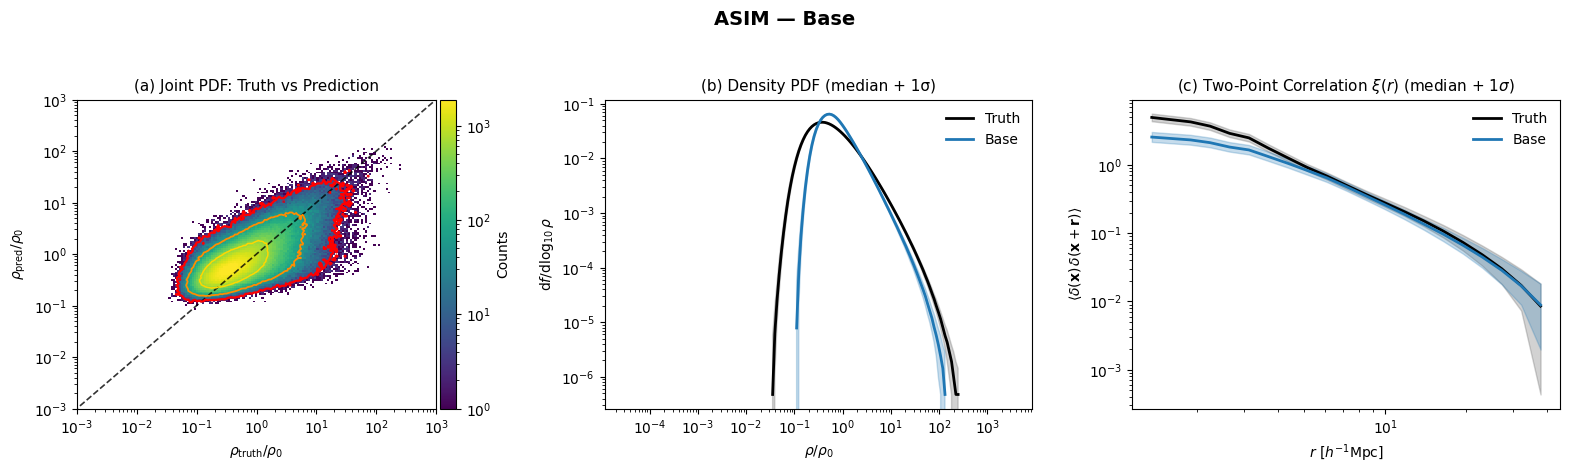

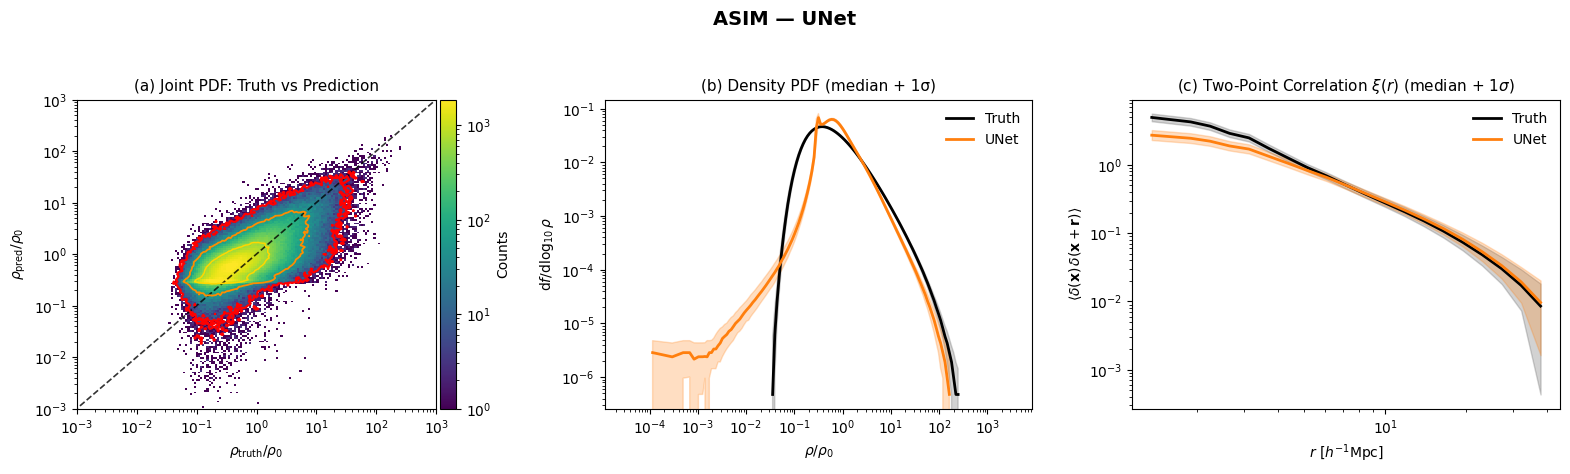

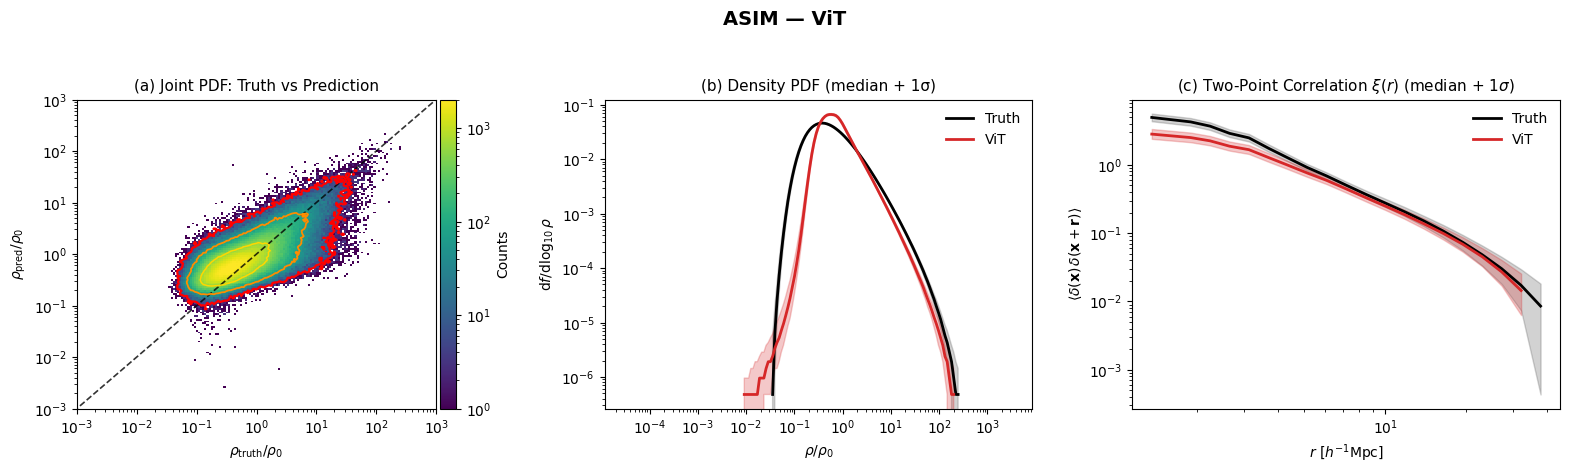

In [22]:
PATH = "/home/mingyeong/251105_evaluation/src/struct_outputs"

fig_base = plot_base_panel(PATH, title="ASIM")
fig_unet = plot_unet_panel(PATH, title="ASIM")
fig_vit  = plot_vit_panel(PATH,  title="ASIM")
